## Alternative Model (Preprocessing)
You need to run this before you run notebook 4b.

The wavs in your dataset will be converted to 9bit linear and 80-band mels.

In [59]:
cd /home/erogol/Projects/WaveRNN/

/home/erogol/Projects/WaveRNN


In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import librosa
import matplotlib.pyplot as plt
import math, pickle, os, glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
from utils import *
from utils.display import *
from utils.generic_utils import load_config
from utils.audio import AudioProcessor
import IPython.display as ipd
from multiprocessing import Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
bits = 9
notebook_name = 'wavernn_ljspeech_ref'
config_path = '../TTS/config.json'

CONFIG = load_config(config_path)
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, CONFIG.preemphasis,
                    griffin_lim_iters=50)   

 > Setting up Audio Processor...
 | > fft size: 2048, hop length: 275, win length: 1100


In [62]:
# Point SEG_PATH to a folder containing your training wavs 
# Doesn't matter if it's LJspeech, CMU Arctic etc. it should work fine
SEG_PATH = '/home/erogol/Data/LJSpeech-1.1/wavs/' 
DATA_PATH = f'data/{notebook_name}/'
%mkdir -p $DATA_PATH

In [63]:
def get_files(path, extension='.wav') :
    filenames = []
    for filename in glob.iglob(f'{path}/**/*{extension}', recursive=True):
        filenames += [filename]
    return filenames

In [64]:
wav_files = get_files(SEG_PATH)
print(len(wav_files))

13100


In [65]:
def convert_file(path) :
    wav = ap.load_wav(path, encode=False)
    mel = ap.melspectrogram(wav)
    quant = (wav + 1.) * (2**bits - 1) / 2
    quant = quant.clip(0,2**bits-1)
    return mel.astype(np.float32), quant.astype(np.int), wav

# def convert_file(path) :
#     wav = ap.load_wav(path)
#     quant = ap.mulaw_encode(wav, 2**bits)
#     mel = ap.melspectrogram(wav)
#     return mel.astype(np.float32), quant.astype(np.int)

In [73]:
wav_file = "/home/erogol/Data/LJSpeech-1.1/wavs/LJ018-0016.wav"
m, x, wav = convert_file(wav_files[1])

In [74]:
print(x.max())
print(x.min())

389
151


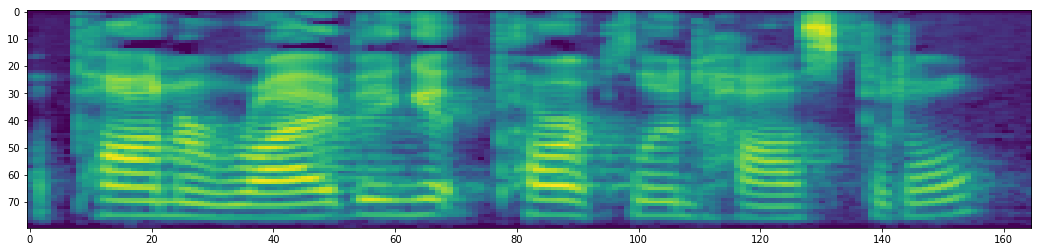

In [75]:
plot_spec(m)

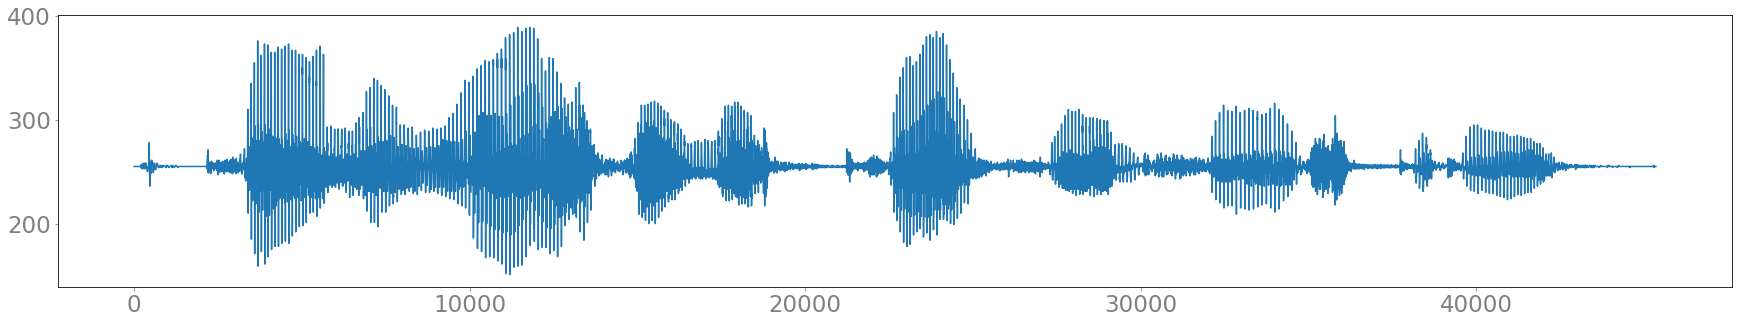

In [76]:
plot(x)

In [77]:
x = 2 * x / (2**bits - 1) - 1

In [78]:
# x_decoder = ap.mulaw_decode(x, 2**bits)
librosa.output.write_wav(DATA_PATH + 'test_quant.wav', x, sr=CONFIG.sample_rate)
ipd.Audio(x, rate=CONFIG.sample_rate)

In [81]:
ipd.Audio(wav_files[1]) # load a local WAV file

In [29]:
QUANT_PATH = DATA_PATH + 'quant/'
MEL_PATH = DATA_PATH + 'mel/'
%mkdir -p $QUANT_PATH
%mkdir -p $MEL_PATH

In [30]:
wav_files[0].split('/')[-1][:-4]

'LJ039-0124'

In [31]:
def process_wav(wav_path):
    idx = wav_path.split('/')[-1][:-4]
    m, x, wav = convert_file(wav_path)
    assert x.max() < 2**bits, wav_path
    assert x.min() >= 0
    np.save(f'{MEL_PATH}{idx}.npy', m)
    np.save(f'{QUANT_PATH}{idx}.npy', x)
    return idx

In [32]:
# This will take a while depending on size of dataset
with Pool(8) as p:
    dataset_ids = list(tqdm(p.imap(process_wav, wav_files), total=len(wav_files)))

In [33]:
with open(DATA_PATH + 'dataset_ids.pkl', 'wb') as f:
    pickle.dump(dataset_ids, f)